In [ ]:
!pip install hmmlearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
!pip install yfinance

In [ ]:
import warnings
import time
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
import yfinance as yf

warnings.filterwarnings("ignore", category=DeprecationWarning)

PLOT_SHOW = True
PLOT_TYPE = False

NUM_TEST = 100
K = 50
NUM_ITERS = 10000

STOCKS = ['S&P500']
labels = ['Close', 'Open', 'High', 'Low']
likelihood_vect = np.empty([0, 1])
aic_vect = np.empty([0, 1])
bic_vect = np.empty([0, 1])

# Possible number of states in Markov Model
STATE_SPACE = range(2, 15)

# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):
    return np.mean(np.abs((true_data - predicted_data) / true_data)) * 100

# Downloading data for the selected stock:
ticker = "^GSPC"  # Change to the desired stock ticker
start_date = "2010-01-01"
end_date = "2024-05-01"
df_0 = yf.download(ticker, start=start_date, end=end_date)
df_0

df_selected = df_0[['Close', 'Open', 'High', 'Low']]

df = df_selected.iloc[::-1]

# Displaying the selected columns DataFrame
print(df_selected)

for stock in STOCKS:
    dataset = df.values
    predicted_stock_data = np.empty([0, dataset.shape[1]])
    likelihood_vect = np.empty([0, 1])
    aic_vect = np.empty([0, 1])
    bic_vect = np.empty([0, 1])

    for states in STATE_SPACE:
        num_params = states**2 + states
        dirichlet_params_states = np.random.randint(1, 50, states)
        model = hmm.GaussianHMM(n_components=states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS)
        model.fit(dataset[NUM_TEST:, :])

        if model.monitor_.iter == NUM_ITERS:
            print('Increase number of iterations')
            sys.exit(1)

        likelihood_vect = np.vstack((likelihood_vect, model.score(dataset)))
        aic_vect = np.vstack((aic_vect, -2 * model.score(dataset) + 2 * num_params))
        bic_vect = np.vstack((bic_vect, -2 * model.score(dataset) + num_params * np.log(dataset.shape[0])))

    opt_states = np.argmin(bic_vect) + 2
    print('Optimum number of states are {}'.format(opt_states))

    for idx in reversed(range(NUM_TEST)):
        train_dataset = dataset[idx + 1:, :]
        test_data = dataset[idx, :]
        num_examples = train_dataset.shape[0]

        if idx == NUM_TEST - 1:
            model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='stmc')
        else:
            model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='')
            model.transmat_ = transmat_retune_prior
            model.startprob_ = startprob_retune_prior
            model.means_ = means_retune_prior
            model.covars_ = covars_retune_prior

        model.fit(np.flipud(train_dataset))

        transmat_retune_prior = model.transmat_
        startprob_retune_prior = model.startprob_
        means_retune_prior = model.means_
        covars_retune_prior = model.covars_

        if model.monitor_.iter == NUM_ITERS:
            print('Increase number of iterations')
            sys.exit(1)

        iters = 1
        past_likelihood = []
        curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))

        while iters < num_examples / K - 1:
            past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
            iters += 1

        likelihood_diff_idx = np.argmin(np.abs(past_likelihood - curr_likelihood))
        predicted_change = train_dataset[likelihood_diff_idx, :] - train_dataset[likelihood_diff_idx + 1, :]
        predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1, :] + predicted_change))

    np.savetxt('{}_forecast.csv'.format(stock), predicted_stock_data, delimiter=',', fmt='%.2f')

    mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(100), :]))
    print('MAPE for the stock {} is '.format(stock), mape)



[*********************100%%**********************]  1 of 1 completed


                  Close         Open         High          Low
Date                                                          
2010-01-04  1132.989990  1116.560059  1133.869995  1116.560059
2010-01-05  1136.520020  1132.660034  1136.630005  1129.660034
2010-01-06  1137.140015  1135.709961  1139.189941  1133.949951
2010-01-07  1141.689941  1136.270020  1142.459961  1131.319946
2010-01-08  1144.979980  1140.520020  1145.390015  1136.219971
...                 ...          ...          ...          ...
2024-04-24  5071.629883  5084.859863  5089.479980  5047.020020
2024-04-25  5048.419922  5019.879883  5057.750000  4990.580078
2024-04-26  5099.959961  5084.649902  5114.620117  5073.140137
2024-04-29  5116.169922  5114.129883  5123.490234  5088.649902
2024-04-30  5035.689941  5103.779785  5110.830078  5035.310059

[3605 rows x 4 columns]
Optimum number of states are 12
MAPE for the stock S&P500 is  0.7018829648322351


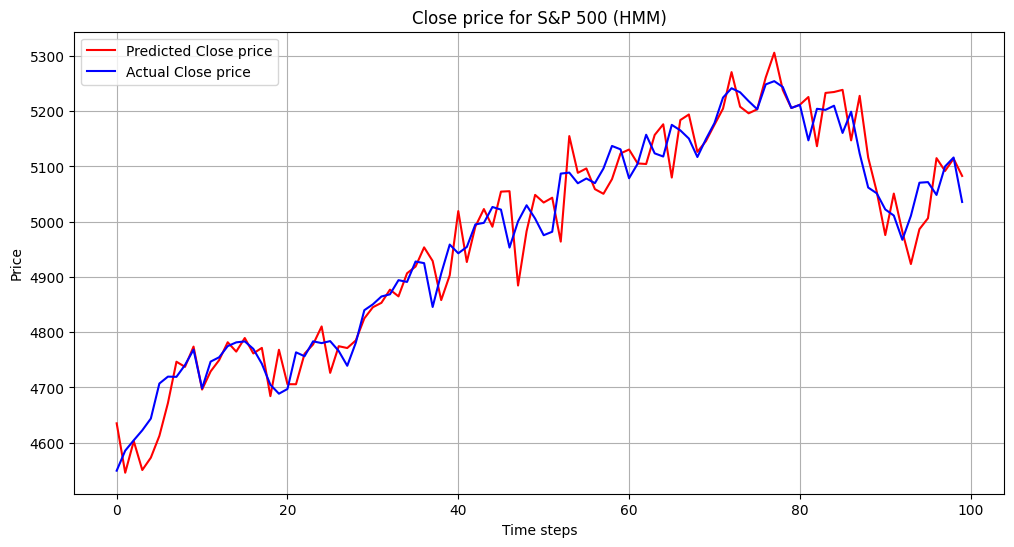

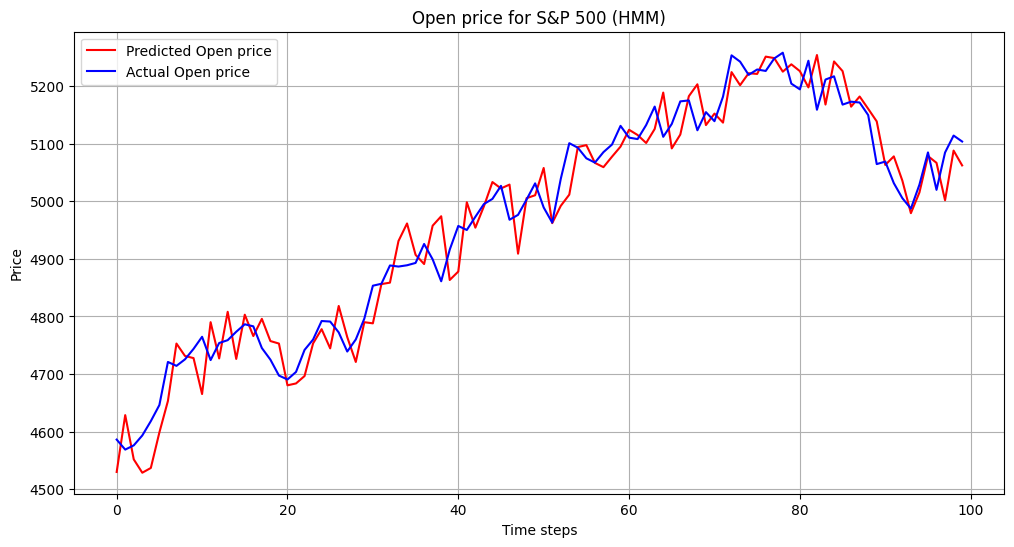

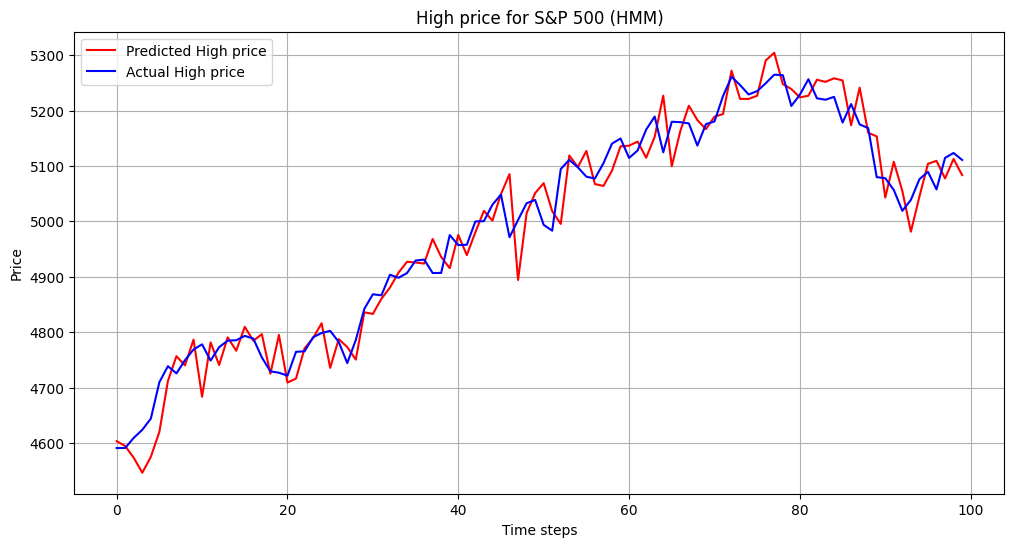

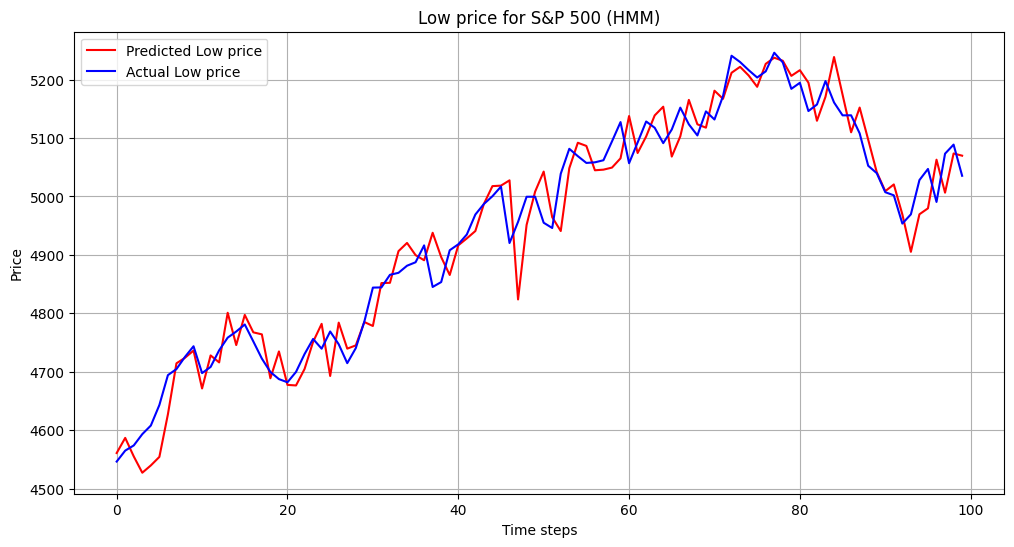

In [ ]:
    if PLOT_TYPE:
        plt.figure(figsize = (12,6))
        plt.plot(range(100), predicted_stock_data)
        plt.title('Predicted stock prices')
        plt.legend(('Close', 'Open', 'High', 'Low'))
        plt.xlabel('Time steps')
        plt.ylabel('Price')
        plt.figure()
        plt.plot(range(100), np.flipud(dataset[range(100), :]))
        plt.title('Actual stock prices')
        plt.legend(('Close', 'Open', 'High', 'Low'))
        plt.xlabel('Time steps')
        plt.ylabel('Price')
    else:
        for i in range(4):

            plt.figure(figsize = (12,6))
            plt.plot(range(100), predicted_stock_data[:, i], 'r', label='Predicted ' + labels[i] + ' price')
            plt.plot(range(100), np.flipud(dataset[range(100), i]), 'b', label='Actual ' + labels[i] + ' price')
            plt.xlabel('Time steps')
            plt.ylabel('Price')
            plt.title(labels[i] + ' price' + ' for ' + "S&P 500 (HMM)")
            plt.grid(True)
            plt.legend(loc='upper left')

    if PLOT_SHOW:
        plt.show(block=False)

In [ ]:
from sklearn.metrics import r2_score

# Calculate the R2 score
r2 = r2_score(np.flipud(dataset[range(99), :]),predicted_stock_data[:-1])

print("R2 score:", r2)

R2 score: 0.9128525027735845


In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(np.flipud(dataset[range(99), :]), predicted_stock_data[:-1])
mae_percentage = (mae / np.mean(np.flipud(dataset[range(99), :]))) * 100
print("Mean absolute error on test set: {:.2f}%".format(mae_percentage))

Mean absolute error on test set: 0.89%


In [ ]:
# prompt: predicted_stock_data I just want the first data value of each []

RealcloseHMM = []
for data_point in np.flipud(dataset[range(100), :]):
  RealcloseHMM.append(data_point[0])


closeHMM = []
for data_point in predicted_stock_data:
  closeHMM.append(data_point[0])


In [ ]:
test = []
signal = []
for i in range(1,len(RealcloseHMM)):
  if RealcloseHMM[i] > RealcloseHMM[i-1]:
    test.append(1)
  else:
    test.append(-1)

for i in range(1,len(closeHMM)):
  if closeHMM[i] > closeHMM[i-1]:
    signal.append(1)
  else:
    signal.append(-1)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics  import roc_auc_score
accuracy_score(test,signal)

0.5353535353535354

In [ ]:
confusion_matrix(test,signal)

array([[18, 25],
       [21, 35]])

Text(0, 0.5, 'True Positive Rate')

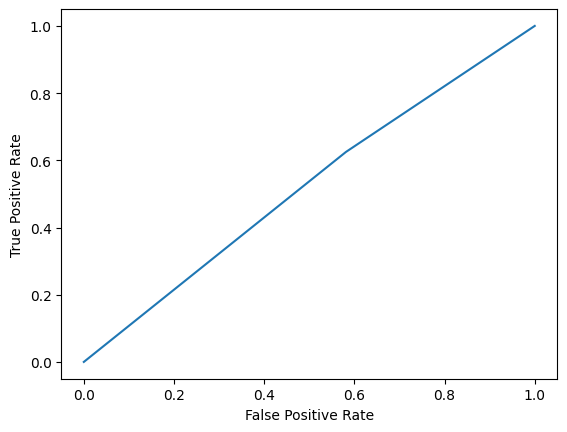

In [ ]:
fpr, tpr, thresholds = roc_curve(test,signal)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
roc_auc_score(test,signal)

0.5218023255813954

In [ ]:
N = 100

df_equity =pd.DataFrame()
equity = [100]

TP = 0.03
SL = 0.01

pos = 0
price = 0

for i in range(1,N-1):

  equity.append(equity[i-1])

  if pos == 1:
    if RealcloseHMM [i] >= price*(1+TP):
      pos = 0
      equity[i] *= (1+TP)

    elif RealcloseHMM [i] <= price*(1-SL):
      pos = 0
      equity[i] *=(1-SL)

  elif pos == -1:

    if RealcloseHMM [i] <= price*(1-TP):
      pos = 0
      equity[i] *= (1+TP)

    elif RealcloseHMM [i] >= price*(1+SL):
      pos = 0
      equity[i] *=(1-SL)

  else:

    if test[i] !=0:
      pos = test[i]
      price = RealcloseHMM[i]

df_equity["Equity"] = equity

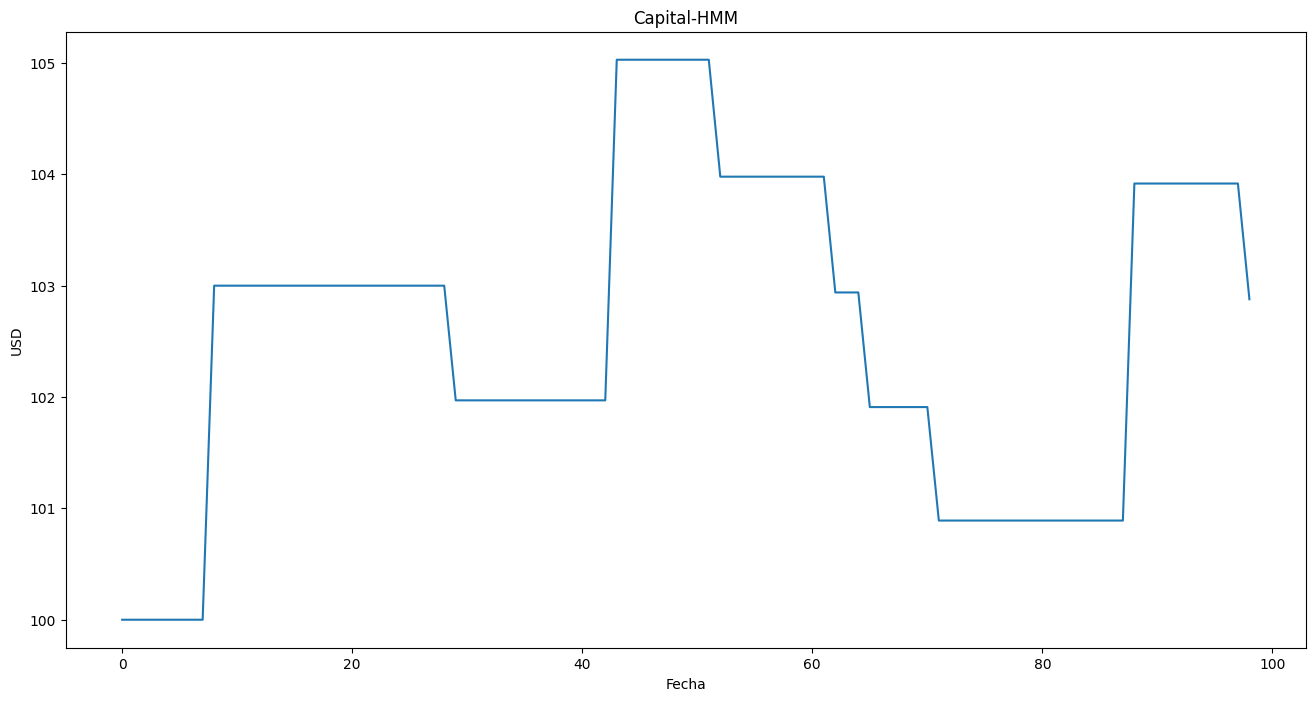

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df_equity["Equity"])
plt.title("Capital-HMM")
plt.xlabel("Fecha")
plt.ylabel("USD")
plt.show()

In [ ]:
ret =np.log(df_equity["Equity"]).diff().mean()
ret *= 252
vol =np.log(df_equity["Equity"]).diff().std()
vol *= np.sqrt(252)
vol

rf =  0.01
sharpe_ratio = (ret-rf)/vol
sharpe_ratio

0.6885064683152122

In [ ]:
df_equity

,Equity
0,100.000000
1,100.000000
2,100.000000
3,100.000000
4,100.000000
...,...
94,103.917250
95,103.917250
96,103.917250
97,103.917250
